# Laminar Flow over Backward Facing Step (2D)
This notebook implements a steady incompressible Navier-Stokes solver for the BFS problem.

In [1]:
import numpy as np
import pandas as pd

# Mesh generation
import gmsh
import dolfinx
from dolfinx.io import gmshio
from mpi4py import MPI

import matplotlib.pyplot as plt
from matplotlib import cm

import sys

mesh_path      = '../../../mesh/'
benchmark_path = '../../../BenchmarkData/'

sys.path.append('../../../models/fenicsx')

Mesh generation from *gmsh*

In [2]:
gdim = 2
model_rank = 0
mesh_comm = MPI.COMM_WORLD

mesh_factor = .1

# Initialize the gmsh module
gmsh.initialize()

zeta_comp_step = 1
H = 2 * zeta_comp_step
h = zeta_comp_step
L = 36 * zeta_comp_step
l = 25 * zeta_comp_step

# Load the .geo file
gmsh.merge(mesh_path+'bfs.geo')
gmsh.model.geo.synchronize()

gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)

gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

# Domain
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )
gmsh.finalize()
    
bound_markers = {'inlet':  10,
                 'walls':  20, 
                 'outlet': 30}

domain_marker = 100

Info    : Reading '../../mesh/bfs.geo'...
Info    : Done reading '../../mesh/bfs.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 80%] Meshing curve 9 (Line)
Info    : [ 90%] Meshing curve 10 (Line)
Info    : Done meshing 1D (Wall 0.00222577s, CPU 0.00221s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 1.1057s, CPU 1.02919s)
Info    : 19120 nodes 38626 elements
Info    : Optimizing mesh (Netgen)...
Info    : Done optimizing mesh (Wall 2.17999e-06s, CPU 3e-06s)


The problem we want to face is non-linear, whose weak formulation reads:
\begin{equation}
\int_\Omega \left(\mathbf{u}\cdot \nabla\right)\mathbf{u}\cdot \mathbf{v}\,d\Omega + \nu \int_\Omega\nabla \mathbf{u}\cdot \nabla \mathbf{v}\,d\Omega -\int_\Omega p(\nabla\cdot\mathbf{v})\,d\Omega -\int_\Omega q(\nabla\cdot\mathbf{u})\,d\Omega=0
\end{equation}

In [3]:
from fluid_dynamics.steady_ns import ns_steady_nl

bfs = ns_steady_nl(domain, ct = ct, ft = ft, bound_markers=bound_markers)

ReynoldsNumber = 100

boundary_type = {'inlet':  0,
                 'walls':  1,
                 'outlet': 2}
boundary_value = {'inlet': np.array([1., 0, 0])}

bfs.parameters(nu = boundary_value['inlet'][0] * h / ReynoldsNumber)
bfs.set_bc(boundary_type, boundary_value)
bfs.assemble(maxIter = 20, verbose = True)

up_sol = bfs.solve()
(u_sol, p_sol) = (up_sol.sub(0).collapse(), up_sol.sub(1).collapse())

0 6.257028296972611
1 0.0653375501264569
2 0.021138628858773174
3 0.003200341389534335
4 0.00019625164625130574
5 7.115213714587669e-07
6 1.5351339529065506e-11


Let us make some contour plots using *pyvista*

In [4]:
# xdmf = dolfinx.io.XDMFFile(domain.comm, "bfs.xdmf", "w")
# xdmf.write_mesh(domain)
# u_sol.name = "U"
# # p_sol.name = "p"

# xdmf.write_function(u_sol, 0.)
# # xdmf.write_function(p_sol, 0.)
# xdmf.close()

## Comparison with benchmark data
Benchmark data are taken from Armaly

In [6]:
def extract1D_y(problem, u_sol, x_lines: list, y_grid: np.ndarray, component = 0):

    u_extracted = list()
    y_plot      = list()

    for idx_y in range(len(x_lines)):
        
        N = len(y_grid)
        points = np.zeros((3, N))
        points[0, :] = x_lines[idx_y]
        points[1, :] = y_grid
        
        bb_tree = dolfinx.geometry.BoundingBoxTree(problem.domain, problem.domain.topology.dim)
        cells = []
        points_on_proc = []
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
        colliding_cells = dolfinx.geometry.compute_colliding_cells(problem.domain, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i))>0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        xPlot = np.array(points_on_proc, dtype=np.float64)

        if np.isclose(component, 0):
            u_extracted.append( u_sol.sub(0).eval(xPlot, cells).flatten() )
        else:
            u_extracted.append( u_sol.sub(1).eval(xPlot, cells).flatten() )
        y_plot.append( xPlot[:,1] )
        
    return u_extracted, y_plot

x_lines = np.array([0.00, 4.00, 4.88, 6.11, 8.17, 14.29]) * h - 4 * zeta_comp_step
N = 100

ux, y_plot = extract1D_y(bfs, u_sol, x_lines, np.linspace(-h, H, 100), component = 0)

##### Loading benchmark data #####
bench_data = [pd.read_csv(benchmark_path+'fluid_dynamics/bfs/exp{:.2f}'.format((x_lines[ii] + 4 * zeta_comp_step)/ h)+'.csv', skiprows=0).to_numpy()
              for ii in range(len(x_lines))]

bench_data[1][:, 0] = bench_data[1][:, 0] - (x_lines[1] + 4 * zeta_comp_step) / h
bench_data[3][:, 0] = bench_data[3][:, 0] - (x_lines[3] + 4 * zeta_comp_step) / h
bench_data[4][:, 0] = bench_data[4][:, 0] - (x_lines[4] + 4 * zeta_comp_step) / h
bench_data[5][:, 0] = bench_data[5][:, 0] - (x_lines[5] + 4 * zeta_comp_step) / h

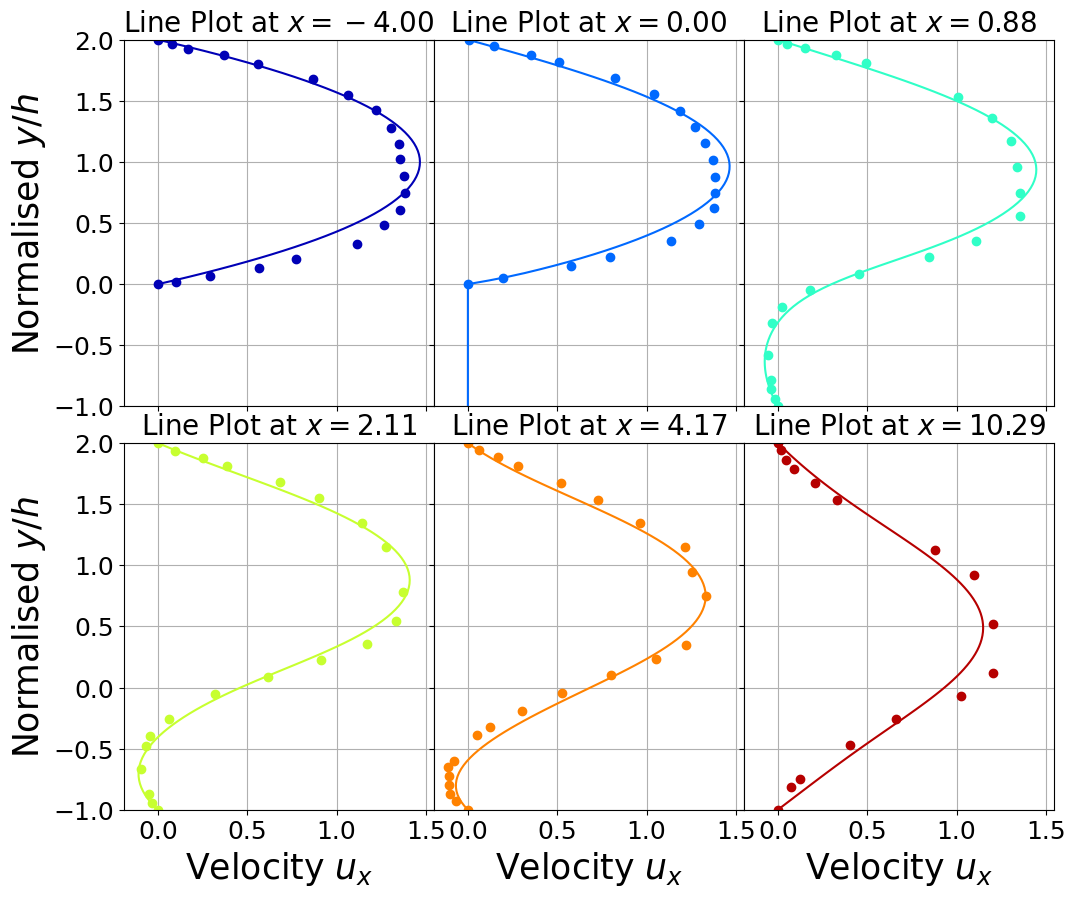

In [7]:
nrows = 2
ncols = 3

fig, axs = plt.subplots(nrows = nrows, ncols = ncols, sharey = True, sharex = True, figsize=(4*ncols, 5 * nrows))
axs = axs.flatten()
fontsize  = 25
labelsize = 18

colors = cm.jet(np.linspace(0.05, 0.95, len(ux)))
for ii in range(len(ux)):
    axs[ii].plot(ux[ii], y_plot[ii] / h, c=colors[ii])
    axs[ii].plot(bench_data[ii][:,0], (bench_data[ii][:,1] - h) / h, 'o', c=colors[ii])
    axs[ii].set_ylim(-1, 2)
    axs[ii].grid()
    axs[ii].set_title(r'Line Plot at $x={:.2f}$'.format(x_lines[ii]), fontsize=fontsize - 5)
    axs[ii].tick_params(axis='both', labelsize=labelsize)
    axs[ii].set_xticks(np.arange(0, 1.6, 0.5))
    
axs = axs.reshape(nrows, ncols)

axs[0, 0].set_ylabel(r'Normalised $y/h$', fontsize = fontsize)
axs[1, 0].set_ylabel(r'Normalised $y/h$', fontsize = fontsize)

for col in range(ncols):
    axs[1, col].set_xlabel(r'Velocity $u_x$', fontsize = fontsize)
    
fig.subplots_adjust(wspace=0, hspace=0.1)